# Testing cartopy and regionmask libraries

I founf this very usefull tool for working with geospacial data and standar regions calle 'regionmask'

https://regionmask.readthedocs.io/en/v0.3.1/whats_new.html

In [1]:
# Libraries
import regionmask
import matplotlib.pyplot as plt

# Custom functions
import sys

sys.path.append("../src")
from processing import load_zip, holmes, apply_scaling

# Global variables
eq_pass = "Ascending"
# eq_pass = "Descending"

temperature_cmap = "jet"
save_figures = True
save_files = True

In [2]:
# Load the data from the zip into a xarray_dataset
path = "../data/raw/ka_sample.zip"
xarray_dataset = load_zip(path)

Loading zipfile from ../data/raw/ka_sample.zip


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


In [3]:
# Apply scaling factors and calculate holme's LST
xarray_dataset = apply_scaling(xarray_dataset)
xarray_dataset["Holmes_LST"] = holmes(xarray_dataset["Brightness Temperature (V)"])

Applying scaling


100%|██████████| 3/3 [00:00<00:00, 130.78it/s]


In [4]:
# Estract the lat and longitude
lat = xarray_dataset["lat"]
lon = xarray_dataset["lon"]

# Create the mask and add it to the xarray dataset
land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(lon, lat)
xarray_dataset["land_mask"] = land_mask

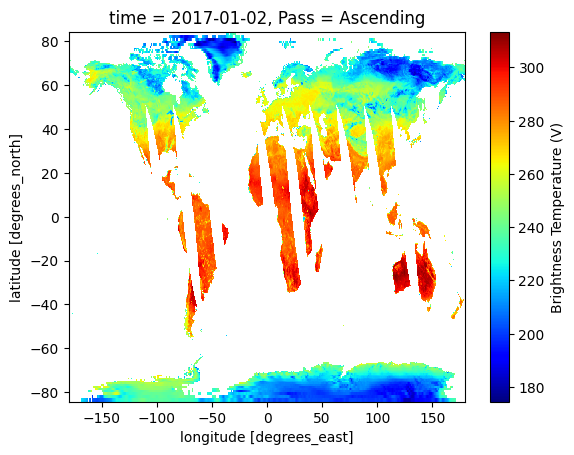

In [5]:
# Define the xarray where the mask is applyed (0 = land, nan = ocean)
land_xarray = xarray_dataset.where(land_mask == 0)
land_xarray["Brightness Temperature (V)"][2, :, :].plot(cmap=temperature_cmap)

In [49]:
# Now lets process the whole zipfile and extract the plot of the mean Holmes temperature for 2017, masking the ocean
path = "../data/raw/ka.zip"
xarray_dataset = load_zip(path)
xarray_dataset

Loading zipfile from C:/Users/andre/PycharmProjects/DATA/ka_sample.zip


100%|██████████| 6/6 [00:00<00:00, 22.57it/s]


<xarray.Dataset>
Dimensions:                     (lon: 1388, lat: 584, time: 3)
Coordinates:
  * lon                         (lon) float32 -179.9 -179.6 ... 179.6 179.9
  * lat                         (lat) float32 -83.52 -81.98 ... 81.98 83.52
  * time                        (time) datetime64[ns] 2017-01-01 ... 2017-01-02
    Pass                        (time) <U10 'Ascending' 'Descending' 'Ascending'
Data variables:
    Brightness Temperature (H)  (time, lat, lon) float32 2.049e+04 ... 2.012e+04
    Brightness Temperature (V)  (time, lat, lon) float32 2.344e+04 ... 2.203e+04
    Time Information            (time, lat, lon) float32 -286.0 ... -1.267e+03
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

In [50]:
# Apply scaling factors and calculate holme's LST
xarray_dataset = apply_scaling(xarray_dataset)
xarray_dataset["Holmes_LST"] = holmes(xarray_dataset["Brightness Temperature (V)"])

Applying scaling


100%|██████████| 3/3 [00:00<00:00, 1197.12it/s]


In [51]:
# Estract the lat and longitude
lat = xarray_dataset["lat"]
lon = xarray_dataset["lon"]

# Create the mask and add it to the xarray dataset
land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(lon, lat)
xarray_dataset["land_mask"] = land_mask

In [46]:
# Select only one pass (Ascending, or Descending)
ascending_dataset = xarray_dataset.where(
    xarray_dataset["Pass"] == "Ascending", drop=True
)
descending_dataset = xarray_dataset.where(
    xarray_dataset["Pass"] == "Descending", drop=True
)

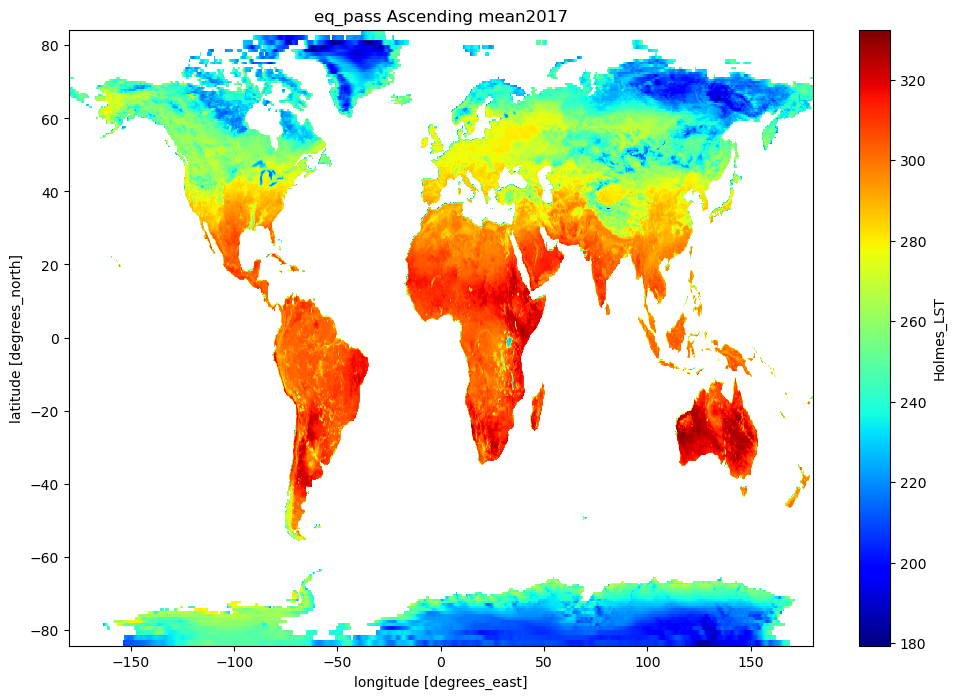

In [47]:
# Calculate the average for each pixel on the map.
ascending2017 = ascending_dataset["Holmes_LST"].mean(dim="time")
plt.figure(figsize=(12, 8))
ascending2017.where(land_mask == 0).plot(cmap=temperature_cmap)

# Save the plot as a png
if save_figures:
    plt.title("eq_pass Ascending mean2017")
    plt.savefig("../figures/2017mean_Ascending_Holmes_Land_LST.png")

# Save the .h5 file
if save_files:
    ascending2017.to_netcdf()

# EQMD
decending2017 = descending_dataset["Holmes_LST"].mean(dim="time")
plt.figure(figsize=(12, 8))
decending2017.where(land_mask == 0).plot(cmap=temperature_cmap)

if save_figures:
    plt.title("eq_pass Ascending mean2017")
    plt.savefig("../figures/2017mean_Descending_Holmes_Land_LST.png")